# GeoPandas: Advanced topics

[GeoHackWeek 2019](https://geohackweek.github.io) -- [vector tutorial](https://geohackweek.github.io/vector/)   
[Emilio Mayorga, University of Washington](https://github.com/emiliom/). 2019-9-9

## 1. Introduction

We covered the basics of GeoPandas in the previous episode and notebook. Here, we'll extend that introduction to illustrate additional aspects of GeoPandas and its interactions with other Python libraries, covering fancier mapping, reprojection, analysis (unitary and binary spatial operators), and raster zonal stats + GeoPandas. 

**Main sections in this episode / notebook:**
- Read HydroBASINS watersheds dataset for Western Washington from a PostGIS / PostgreSQL relational database on the cloud
- Dissolve into larger watersheds, and reproject
- Plot `choropleth` map based on calculated watershed areas
- Choropleth map as an interactive map with folium
- Spatial join, `sjoin`, of polygons on points
- rasterstats: "zonal" statistics from polygons on rasters

## 2. Import packages, and set data file path and database connection credentials

In [1]:
from pathlib import Path
import json
import psycopg2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

In [2]:
mpl.__version__, pd.__version__, gpd.__version__

('3.1.1', '0.25.1', '0.5.1')

In [3]:
# On pangeo, uncomment this line to install this package not present in the pangeo conda environment
# !conda install -y -c conda-forge mapclassify

In [4]:
data_pth = Path("../data")

In [5]:
with open(data_pth / "db.json") as f:
    db_conn_dict = json.load(f)

## 3. Read HydroBASINS North America dataset, extracting Western Washington
Read [HydroBASINS](https://hydrosheds.org/pages/hydrobasins) "all-levels" (lev00) hierarchical watersheds dataset for North America and the Caribbean (`hybas_na_lev00_v1c`), from Amazon Cloud PostgreSQL/PostGIS database. **Watersheds in the dataset are at the finest (highest resolution) "Pfastetter" hierarchical level, level 12.** HydroBASINS dataset technical documentation is [here](https://hydrosheds.org/images/inpages/HydroBASINS_TechDoc_v1c.pdf).

`read_postgis` is called as before, except now we'll apply a SQL filter (*server side -- let the server do extra work for you*) to the PostGIS dataset to select only the Pfastetter level-4 watershed with code 7831: `WHERE pfaf_4 = 7831`. This is **most of Western Washington.** Watershed polygons will still be read at their original level 12 resolution.

<div class="alert alert-info" style="font-size:100%">

For a more in-depth look at interacting with spatial relational databases, see the eScience Institute tutorial [Introduction to SQL and Geospatial Data Processing](https://uwescience.github.io/SQL-geospatial-tutorial/).

</div>

In [6]:
conn = psycopg2.connect(**db_conn_dict)

Note that if the PostGIS geometry column (`geom_col` argument) is not called `geometry`, we have to know its name in advance. Bummer.

In [7]:
hydrobas_ww = gpd.read_postgis(
    "SELECT * FROM hybas_na_lev00_v1c WHERE pfaf_4 = 7831", conn, 
    geom_col='polygongeom',
    coerce_float=False)

In [8]:
conn.close()

In [9]:
hydrobas_ww.crs

{'init': 'epsg:4326'}

In [10]:
len(hydrobas_ww)

413

413 polygon features returned. Let's examine the attributes available, using the first feature as an example.

In [11]:
hydrobas_ww.iloc[0]

gid                                                        19945
hybas_id                                             7.00001e+09
next_down                                                      0
next_sink                                            7.00001e+09
main_bas                                             7.00001e+09
dist_sink                                                      0
dist_main                                                      0
sub_area                                                   135.4
up_area                                                    135.4
endo                                                           0
coast                                                          0
order                                                          1
sort                                                       19945
pfaf_1                                                         7
pfaf_2                                                        78
pfaf_3                   

**Plot a categorical map with coloring based on the aggregating column `pfaf_7`.** Watershed *boundaries* are at the high-resolution Pfastetter level 12.   
Note: pick a color map (`cmap`) appropriate for your data. [Get to know the matplotlib color maps.](https://matplotlib.org/tutorials/colors/colormaps.html)

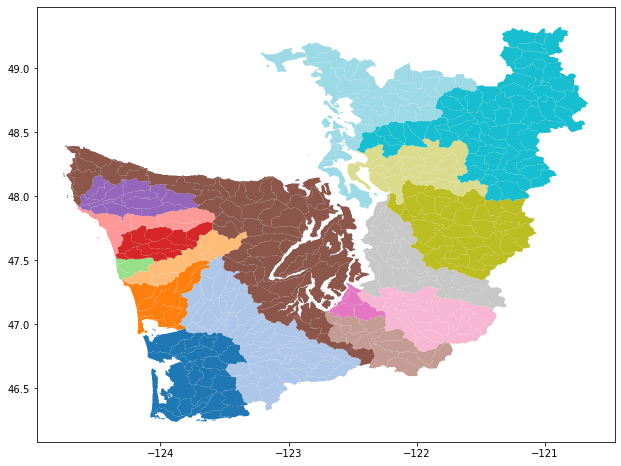

In [12]:
hydrobas_ww.plot(column='pfaf_7', cmap='tab20', categorical=True, figsize=(14, 8));

### Rename the GeoDataFrame geometry column from `polygongeom` to `geometry` to avoid issues with other packages
Unfortunately, `folium` choropleth and `rasterstats` (demonstrated below) require the geometry column to be named "geometry" (as of 2018-9). So, we'll rename it here first.

In [13]:
hydrobas_ww = hydrobas_ww.rename(columns={'polygongeom': 'geometry'})
hydrobas_ww._geometry_column_name = 'geometry'

## 4. Dissolve into larger watersheds, and reproject

### Dissolve source polygons into larger watersheds based on attribute values
Apply GeoDataFrame [dissolve](http://geopandas.org/aggregation_with_dissolve.html) aggregation method (implemented from lower-level `shapely` operators) on level-7 Pfastetter codes (`pfaf_7`) shown in the plot above. Aggregate attributes, retaining only `pfaf_7` and `pfaf_6` (plus `geometry`, of course).

In [14]:
cols = ['pfaf_6', 'pfaf_7', 'geometry']
hydrobas_ww_p7 = hydrobas_ww[cols].dissolve(by='pfaf_7', aggfunc='first', as_index=False)
len(hydrobas_ww_p7)

17

This operation resulted in only 17 polygons, from the original 413. Let's examine some of the features.

In [15]:
hydrobas_ww_p7.head()

,pfaf_7,geometry,pfaf_6
0,7831010,(POLYGON ((-123.4666666666666 46.2666666666666...,783101
1,7831020,POLYGON ((-123.1791666666666 46.33333333333336...,783102
2,7831031,(POLYGON ((-123.9597222222222 46.9666666666667...,783103
3,7831032,POLYGON ((-123.8583333333333 47.39583333333336...,783103
4,7831033,"POLYGON ((-124.3 47.34583333333336, -124.30221...",783103


Plot the results. Looks like the previous plot, except the polygon boundaries are now the pfaf_7 watersheds.

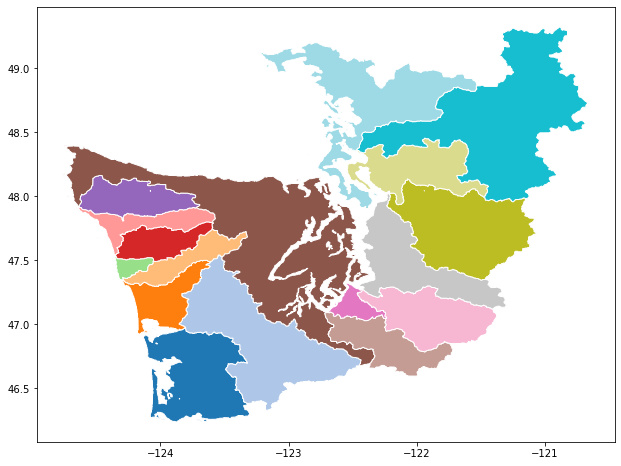

In [16]:
hydrobas_ww_p7.plot(column='pfaf_7', cmap='tab20', categorical=True, edgecolor='white',
                    figsize=(14, 8));

<div class="alert alert-warning" style="font-size:100%">
<b style="font-size:120%">Beware of invalid geometries!</b></br>

**Beware that *dissolve* may fail if there are "invalid" geometries.** The code below is based on a GeoDataFrame examined in the previous, intro notebook. The 6 geometries/points reported are invalid (and are reported by the *is_valid()* method). This dissolve statement does work, though.

```python
seas_grp = seas[['oceans', 'geometry']]
seas_oceans_diss = seas_grp[seas_grp.geometry.is_valid].dissolve(by='oceans')

Ring Self-intersection at or near point 10.407218181818182 54.821390909090908
Self-intersection at or near point -79.365827272727287 76.296645454545455
Ring Self-intersection at or near point 10.979445510225332 54.380555030408686
Ring Self-intersection at or near point 133.61550925464189 -4.3005540903175188
Ring Self-intersection at or near point 121.91067196634913 -5.0593090510592447
Ring Self-intersection at or near point 115.29553592754269 -7.0082630551828515
```

</div>

### Reproject (transform) to WA State Plane South, epsg:2927
Partly so we can calculate polygon areas in planar units, not geodetic degrees. But also because that's the projection used by most state and local governments in Washington.

<div class="alert alert-info" style="font-size:100%">

Projections can be explored at various web resources.For example these links rely on different systems to provide information about `epsg:2927`:

- http://epsg.io/2927
- http://spatialreference.org/ref/epsg/2927/
- [Report from http://www.epsg-registry.org](http://www.epsg-registry.org/report.htm?type=selection&entity=urn:ogc:def:crs:EPSG::2927&reportDetail=short&style=urn:uuid:report-style:default-with-code&style_name=OGP%20Default%20With%20Code&title=EPSG:2927)
    
We can extract the epsg code from the GeoDataFrame `crs` property (from the string returned by `crs['init']`), then pass it to `pyepsg` to programmatically obtain information about a projection:
```python
import pyepsg
pyepsg.get(hydrobas_ww_p7.crs['init'].split(':')[1])
```

</div>

Let's use `pyepsg`, which issues queries to http://epsg.io web services, to examine the properties of a projection.

In [17]:
import pyepsg
pyepsg.get('2927')

<ProjectedCRS: 2927, NAD83(HARN) / Washington South (ftUS)>

**Apply the crs transformation (reprojection)** using `to_crs` method.

In [18]:
hydrobas_ww_p7_wasp = hydrobas_ww_p7.to_crs(epsg=2927)

**Plot the reprojected map.** Note that, being in a planar project (not geodetic), the shape looks different compared to the previous map. More "normal". And the axes are now in `feet` relative to some origin.

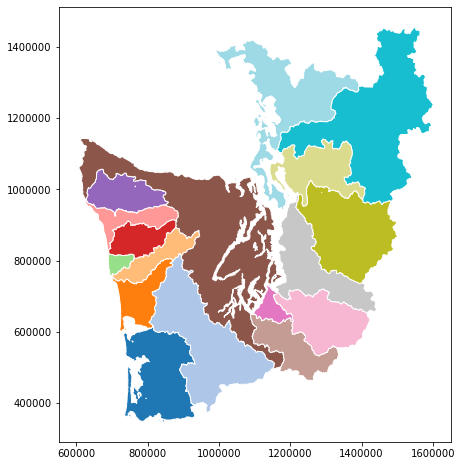

In [19]:
hydrobas_ww_p7_wasp.plot(column='pfaf_7', cmap='tab20', categorical=True, edgecolor='white',
                         figsize=(14, 8));

## 5. Plot `choropleth` map based on calculated watershed areas
As the projection is in `feet`, auto-calculated polygon areas will be in feet<sup>2</sup>. So let's convert to miles<sup>2</sup> first (why not!). We'll add a new column to the GeoDataFrame.

In [20]:
hydrobas_ww_p7_wasp['area_mi2'] = hydrobas_ww_p7_wasp.geometry.area / 27878400
hydrobas_ww_p7_wasp.head(3)

,pfaf_7,geometry,pfaf_6,area_mi2
0,7831010,(POLYGON ((890315.2572612339 354459.8899780852...,783101,1375.137396
1,7831020,"POLYGON ((963803.8027083555 376154.996568859, ...",783102,2107.945774
2,7831031,(POLYGON ((776917.1877152117 614568.3833321583...,783103,528.472846


<div class="alert alert-info" style="font-size:100%">
<b style="font-size:120%">Pandas "groupby" aggregation</b></br>

You could calculate the area of a pfaf_6 watershed via simple Pandas DataFrame *groupby* aggregation (sum).

</div>

### Plot the choloropleth, using `area_mi2`.

<div class="alert alert-info" style="font-size:100%">
<b style="font-size:120%">Choropleth classifiers from PySAL mapclassify</b></br>

The "fisher_jenks" value segmentation `scheme` (using 7 segments, k=7) used is one of the available choropleth classifiers from the powerful [PySAL Library (Python Spatial Analysis Library)](http://pysal.org/), specifically from its [mapclassify](https://pysal.org/mapclassify/) package. GeoPandas can use these classifiers if `mapclassify` is installed, as it is here. To get the list of classifiers, use:
```python
import mapclassify
print(mapclassify.CLASSIFIERS)
```

</div>

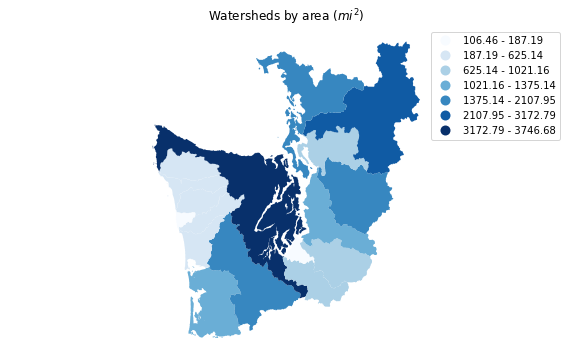

In [21]:
f, ax = plt.subplots(1, figsize=(10, 6))
ax.set_title('Watersheds by area ($mi^2$)')
hydrobas_ww_p7_wasp.plot(column='area_mi2', scheme='fisher_jenks', k=7, 
                         cmap=plt.cm.Blues, legend=True, ax=ax)
ax.set_axis_off()
plt.axis('equal');

<div class="alert alert-success" style="font-size:100%">
<b style="font-size:120%">Time to Explore</b></br>

Let's stop for a bit to explore on your own, hack with your neighbors, ask questions.

</div>

## 6. Choropleth map as an interactive map with folium
[Folium](https://github.com/python-visualization/folium) is very cool, specially for use in Jupyter notebooks; or to export into stand-alone HTML.

In [22]:
import folium

In [23]:
folium.__version__

'0.10.0'

`m.choropleth` internally splits the geometry from the other attributes in `hydrobas_ww_p7_wasp`, and rejoins them based on the key `pfaf_7`. `key_on` uses an attribute reference derived from GeoJSON representations; this is awkward, and hopefully will be simplified in future folium implementations.

In [24]:
hydrobas_ww_p7_wasp.head()

,pfaf_7,geometry,pfaf_6,area_mi2
0,7831010,(POLYGON ((890315.2572612339 354459.8899780852...,783101,1375.137396
1,7831020,"POLYGON ((963803.8027083555 376154.996568859, ...",783102,2107.945774
2,7831031,(POLYGON ((776917.1877152117 614568.3833321583...,783103,528.472846
3,7831032,"POLYGON ((808869.5755557647 769864.5311527678,...",783103,441.528065
4,7831033,"POLYGON ((698711.1808079168 756609.8674803785,...",783103,106.456891


In [25]:
m = folium.Map(location=[47.8, -122.5], zoom_start=7, tiles="cartodbpositron")

folium.Choropleth(
    geo_data=hydrobas_ww_p7_wasp,
    data=hydrobas_ww_p7_wasp,
    columns=['pfaf_7', 'area_mi2'],
    key_on='feature.properties.pfaf_7',
    legend_name='Area (sq mi)', 
    fill_color='YlGn',
    fill_opacity=0.4,
    highlight=True
).add_to(m)

In [26]:
m

This map is interactive, so play with it (zoom and pan). There is a lot more to explore in Folium! This is just a teaser.

## 7. Spatial join, `sjoin`, of polygons on points
We'll use an old, local snapshot of NANOOS coastal and marine monitoring stations in the Pacific NW, from the [NANOOS Visualization System (NVS) Data Explorer](http://nvs.nanoos.org/Explorer). While many stations are moorings on marine waters, some are inshore or in tidal shores and will overlap the watershed boundaries. The point file is in the [GeoPackage](http://www.geopackage.org) format, an OGC format implemented in SQLite.

In [27]:
nanoosstations_gdf = gpd.read_file(data_pth / "nanoos_nvs.gpkg")
len(nanoosstations_gdf)

194

In [28]:
nanoosstations_gdf.iloc[-1]

platform_label                                     WADOH_HendrsnBay1
platform_type                                   Fixed Shore Platform
name                                     Henderson Bay site, W shore
short_name                                       WADOH Henderson Bay
lat                                                          47.3612
lon                                                         -122.697
state                                                     Washington
region                                                   Puget Sound
provider                                                       WADOH
provider_url                                   http://www.doh.wa.gov
provider_type                                                  State
data_source                                                  Decagon
data_source_url                               http://www.decagon.com
url                http://www.doh.wa.gov/CommunityandEnvironment/...
status                            

Points are on the coasts of the Pacific NW (BC, WA, OR) and out in the open ocean.

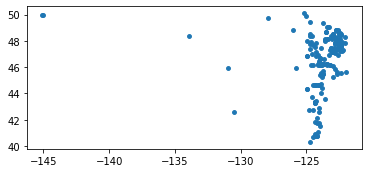

In [29]:
nanoosstations_gdf.plot(markersize=15);

**Apply "inner" spatial join with the `sjoin` operator**. An inner join will retain only overlapping features. Then plot as a map overlay on top of `hydrobas_ww_p7`, categorizing (coloring) each point by the `pfaf_6` watershed it's in.

In [30]:
nanoossta_hydrobas_ww_gdf = gpd.sjoin(nanoosstations_gdf, hydrobas_ww_p7, how="inner")
len(nanoossta_hydrobas_ww_gdf)

63

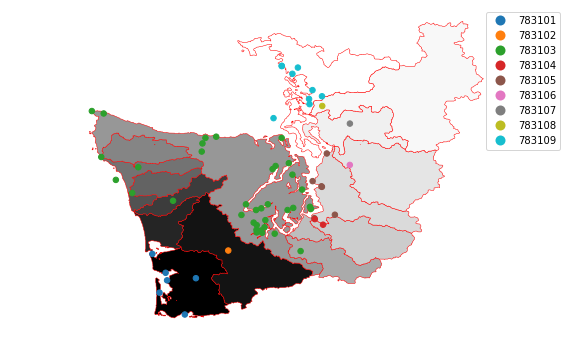

In [31]:
f, ax = plt.subplots(1, figsize=(10, 6))
ax.set_axis_off()
plt.axis('equal')
hydrobas_ww_p7.plot(ax=ax, cmap='Greys_r', linewidth=0.5, edgecolor='red')
nanoossta_hydrobas_ww_gdf.plot(column='pfaf_6', markersize=30, 
                               categorical=True, legend=True, ax=ax);

## 8. rasterstats: "zonal" statistics from polygons on rasters
We'll end by mixing features from a GeoDataFrame with a raster, applying zonal statistics using the cool and light weight [rasterstats](https://github.com/perrygeo/python-rasterstats) package.

Monthly Juy long-term climatology precipitation. The original monthly time series data are from the [PRISM Climate Group](http://prism.oregonstate.edu); the monthly climatology and Pacific NW clip were created by yours truly and Don Setiawan for the [BiGCZ project](http://bigcz.org); it's in geographic (epsg 4326) projection.

In [32]:
ppt_july_tif_pth = data_pth / 'prism_precipitation_july_climatology.tif'

### rasterio

`rasterstas` uses [rasterio](https://mapbox.github.io/rasterio) to read rasters (and `fiona` to read vector datasets), so we'll first do a quick exploration of rasterio.

In [33]:
import rasterio
import rasterio.plot as rioplot

In [34]:
rasterio.__version__

'1.0.28'

In [35]:
ppt_july = rasterio.open(ppt_july_tif_pth)

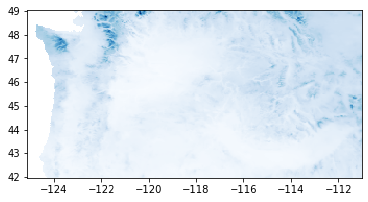

In [36]:
rioplot.show(ppt_july, with_bounds=True, cmap=plt.cm.Blues);

### Apply rasterstas `zonal_stats`

Apply `zonal_stats` from `rasterstats` package. Can pass a `GeoDataFrame` directly (instead of the file path to a GIS file) because it implements our old friend, the `__geo_interface__` method. For the raster, we pass its file path.

`zonal_stats` returns a geojson with the original properties plus the zonal statistics.

In [37]:
import rasterstats as rs

In [38]:
rs.__version__

'0.13.1'

In [39]:
zonal_ppt_gjson = rs.zonal_stats(hydrobas_ww_p7, ppt_july_tif_pth, prefix='pptjuly_',
                                 geojson_out=True)

In [40]:
type(zonal_ppt_gjson), len(zonal_ppt_gjson)

(list, 17)

In [41]:
zonal_ppt_gdf = GeoDataFrame.from_features(zonal_ppt_gjson)
zonal_ppt_gdf.head(2)

,geometry,pfaf_6,pfaf_7,pptjuly_min,pptjuly_max,pptjuly_mean,pptjuly_count
0,(POLYGON ((-123.4666666666666 46.2666666666666...,783101,7831010,23.438837,49.824776,33.674382,259
1,POLYGON ((-123.1791666666666 46.33333333333336...,783102,7831020,15.356521,96.738289,29.443886,404


#### And finally, a choropleth map of July precipitation by watershed! With a good bit of plot tweaking.

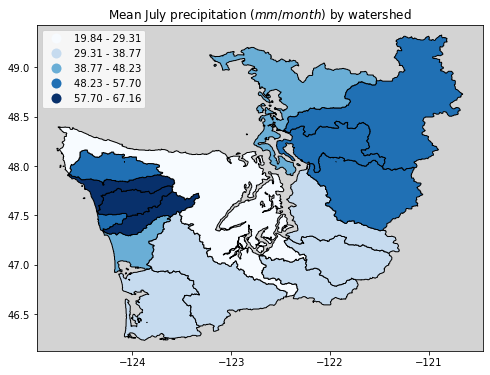

In [42]:
f, ax = plt.subplots(1, figsize=(8, 6))
ax.set_title('Mean July precipitation ($mm/month$) by watershed')
zonal_ppt_gdf.plot(ax=ax, column='pptjuly_mean', scheme='Equal_Interval', k=5, 
                   cmap=plt.cm.Blues, linewidth=1, edgecolor='black', 
                   legend=True, legend_kwds={'loc': 'upper left'})
ax.set_facecolor("lightgray")
plt.axis('equal');